In [1]:
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers 
import numpy as np
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
def read_files(path, extension):
    """Read files with specific extension from directory"""
    if os.path.exists(path):
        return sorted(f for f in os.listdir(path) if f.endswith(extension))

In [3]:
def read_image(image_path):
    """Read and preprocess image"""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [4]:
def read_label(label_path):
    """Read and process label"""
    with open(label_path, 'r') as file:
        lines = file.readlines()
        x_min, y_min = list(map(int, lines[0].strip().split()))
        x_max, y_max = x_min + 28, y_min + 28
        return [x_min, y_min, x_max, y_max]

In [5]:
def data_generator(mapped_data):
    for image_name, label_name in mapped_data.items():
        image = read_image(os.path.join('Images', image_name))
        bbox = read_label(os.path.join('label', label_name))
        yield image, bbox

In [6]:
def prepare_dataset():
    """Prepare and split dataset"""
    # Read files
    img = read_files('Images', '.png')
    labels = read_files('label', '.txt')
    
    # Create mapping
    mapped_data = dict(zip(img, labels))
    
    # Split the mapping
    train_data, test_data = train_test_split(
        list(mapped_data.items()), 
        test_size=0.2, 
        random_state=42
    )
    
    # Convert back to dictionaries
    train_mapped = dict(train_data)
    test_mapped = dict(test_data)
    
    # Create output signature for the datasets
    output_signature = (
        tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(4,), dtype=tf.int32)
    )
    
    # Create training dataset
    train_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(train_mapped),
        output_signature=output_signature
    ).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    
    # Create test dataset
    test_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(test_mapped),
        output_signature=output_signature
    ).batch(32).prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, test_dataset

In [7]:
def build_bbox_model():
    """Build bbox detection model"""
    inputs = keras.Input(shape=(128, 128, 1))
    
    # Enhanced feature extraction
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    
    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    
    output = layers.Dense(4, activation='relu', name='bbox')(x)
    
    return keras.Model(inputs=inputs, outputs=output)

In [8]:
def train_model(train_dataset, test_dataset):
    """Train the model with callbacks and monitoring"""
    model = build_bbox_model()
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            min_delta=0.001,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            'best_model.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False
        )
    ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.Huber(),  
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

In [9]:
def visualize_detection(image, pred_bbox, actual_bbox=None, digit_class=None):
    """Enhanced visualization with optional digit class display"""
    plt.figure(figsize=(10, 10))
    plt.imshow(tf.squeeze(image), cmap="gray")
    
    # Draw predicted bbox
    rect = plt.Rectangle(
        (pred_bbox[0]*128, pred_bbox[1]*128),
        (pred_bbox[2] - pred_bbox[0])*128,
        (pred_bbox[3] - pred_bbox[1])*128,
        edgecolor='red',
        facecolor='none',
        linewidth=2,
        label="Predicted"
    )
    plt.gca().add_patch(rect)
    
    # Draw actual bbox if provided
    if actual_bbox is not None:
        rect = plt.Rectangle(
            (actual_bbox[0]*128, actual_bbox[1]*128),
            (actual_bbox[2] - actual_bbox[0])*128,
            (actual_bbox[3] - actual_bbox[1])*128,
            edgecolor='green',
            facecolor='none',
            linewidth=2,
            label="Actual"
        )
        plt.gca().add_patch(rect)
    
    plt.legend(loc="upper left")
    if digit_class is not None:
        plt.title(f"Detected Digit: {digit_class}")
    plt.axis('off')
    plt.show()

In [10]:
# Prepare dataset
train_dataset, test_dataset = prepare_dataset()

In [ ]:
# Load model or Train model
if os.path.exists('bbox_model.keras'):
    model = keras.models.load_model('bbox_model.keras')
else:    
    model, history = train_model(train_dataset, test_dataset)

Epoch 1/50
932/932 [==============================] - 201s 203ms/step - loss: 7.7021 - mean_absolute_error: 8.1847 - mean_squared_error: 143.0932 - val_loss: 35.9460 - val_mean_absolute_error: 36.4431 - val_mean_squared_error: 1649.8213 - lr: 0.0010
Epoch 2/50
932/932 [==============================] - 152s 156ms/step - loss: 4.8986 - mean_absolute_error: 5.3741 - mean_squared_error: 52.0303 - val_loss: 43.4788 - val_mean_absolute_error: 43.9752 - val_mean_squared_error: 2692.6658 - lr: 0.0010
Epoch 3/50
932/932 [==============================] - 137s 145ms/step - loss: 4.2765 - mean_absolute_error: 4.7488 - mean_squared_error: 41.0708 - val_loss: 4.8864 - val_mean_absolute_error: 5.3769 - val_mean_squared_error: 37.7817 - lr: 0.0010
Epoch 4/50
932/932 [==============================] - 138s 145ms/step - loss: 3.8623 - mean_absolute_error: 4.3323 - mean_squared_error: 33.9141 - val_loss: 109.0295 - val_mean_absolute_error: 109.5294 - val_mean_squared_error: 12927.0176 - lr: 0.0010
Epoc

In [21]:
# Saving model
model.save('bbox_model.h5')
model.save('bbox_model.keras')

In [29]:
def visualize_detection(image, pred_bbox, actual_bbox=None):
    """
    Visualize detection and classification results
    
    Args:
        image: Input image tensor
        pred_bbox: Predicted bounding box coordinates
        actual_bbox: Ground truth bounding box coordinates (optional)
    """
    plt.imshow(tf.squeeze(image), cmap="gray")

    x = max(0, int(pred_bbox[0]))
    y = max(0, int(pred_bbox[1]))
    
    # Draw predicted bbox
    rect = plt.Rectangle(
        (x, y),
        28,
        28,
        edgecolor='red',
        facecolor='none',
        linewidth=2,
        label="Predicted"
    )
    plt.gca().add_patch(rect)
    
    # Draw actual bbox if provided
    if actual_bbox is not None:
        rect = plt.Rectangle(
            (actual_bbox[0], actual_bbox[1]),
            28,
            28,
            edgecolor='green',
            facecolor='none',
            linewidth=2,
            label="Actual"
        )
        plt.gca().add_patch(rect)
    
    plt.legend(loc="upper left")
    plt.title("Digit Detection")
    plt.axis('off')
    plt.show()

Text(0.5, 1.0, 'Loss')

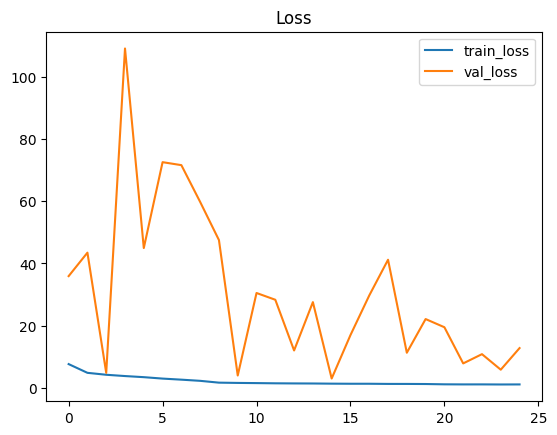

In [ ]:
# Ploting the loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Mean Absolute Error')

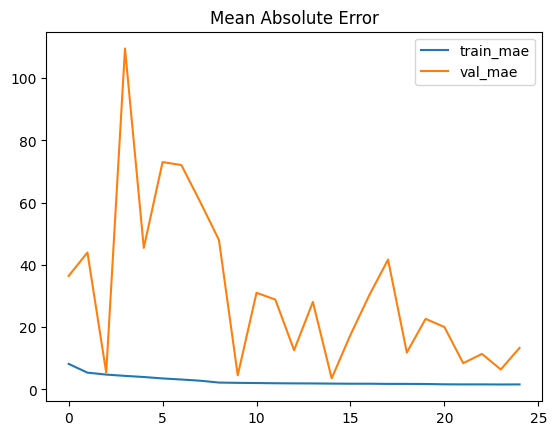

In [34]:
# Plotting the mean absolute error
plt.figure()
plt.plot(history.history['mean_absolute_error'], label='train_mae')
plt.plot(history.history['val_mean_absolute_error'], label='val_mae')
plt.legend()
plt.title('Mean Absolute Error')

Text(0.5, 1.0, 'Mean Squared Error')

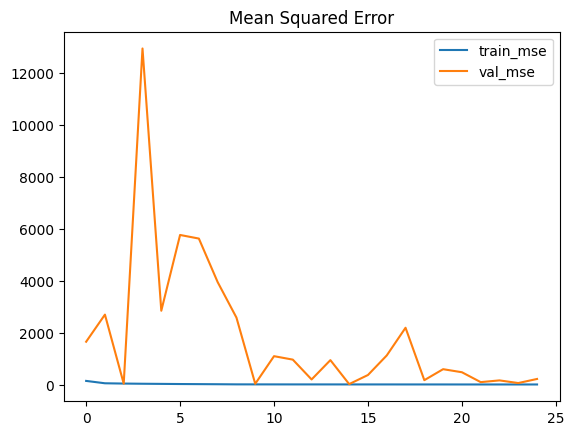

In [35]:
# PLotting the mean squared error
plt.figure()
plt.plot(history.history['mean_squared_error'], label='train_mse')
plt.plot(history.history['val_mean_squared_error'], label='val_mse')
plt.legend()
plt.title('Mean Squared Error')

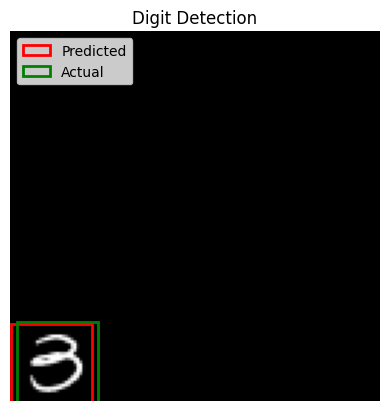

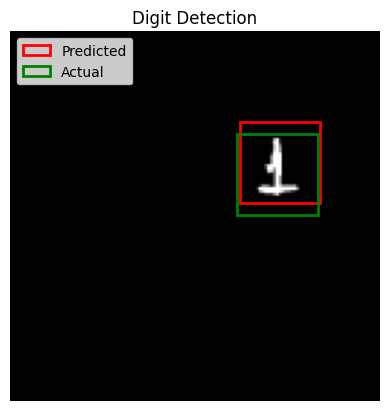

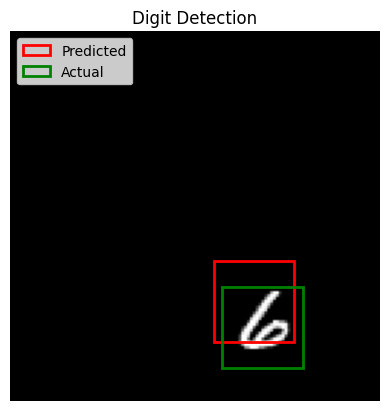

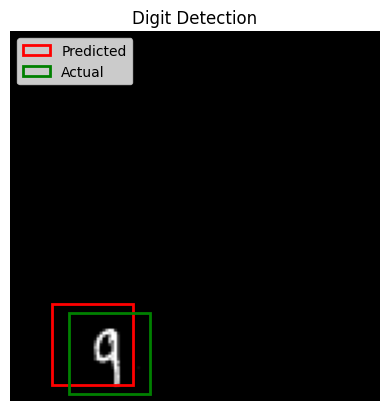

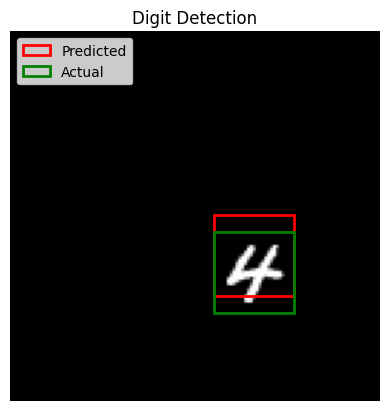

In [30]:
for images, labels in test_dataset.take(5):
    image = images[0]
    actual_bbox = labels[0]
    pred_bbox = model.predict(tf.expand_dims(image, axis=0), verbose=0)[0]
    visualize_detection(image, pred_bbox, actual_bbox)